In [ ]:
# based on https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

In [2]:
# the idea is to only ever train 1 hidden layer at a time
# and freeze the layer after trained and add another layer

In [ ]:
# at each iteration when a new layer gets added
# this should be looped over like 10 times
# and the layer with the smaller MSE should 
# be added

In [ ]:
# only works with constant width layers at the moment

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_test_data():
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)
    return x, y

x, y = gen_test_data()


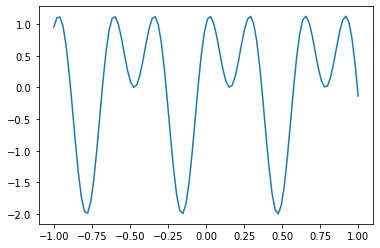

In [3]:
plt.figure()
plt.plot(x, y)
plt.show()
plt.close()

In [64]:
def get_base_model(x, y, verbose=True):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='tanh', input_shape=[1]),
        tf.keras.layers.Dense(200, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=100, epochs=1000, verbose=verbose)
    
    return history, model

In [74]:
%%time
history, model = get_base_model(x, y, verbose=False)

CPU times: user 2.19 s, sys: 340 ms, total: 2.53 s
Wall time: 1.22 s


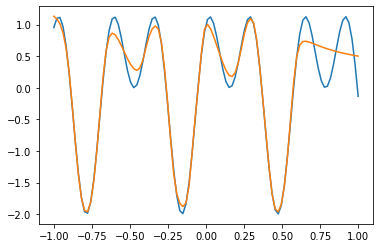

In [75]:
plt.figure()
plt.plot(x, y)
plt.plot(x, model.predict(x))

In [76]:
def add_layer(model, trainX, trainy):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # add a new hidden layer
#     model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    # re-add the output layer
    model.add(output_layer)
    
    # recompile
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    # fit model
    history = model.fit(trainX, trainy, epochs=5000, verbose=0)
    return history, model

In [77]:
# for i in range(4):
#     history2, model2 = add_layer(model2, x, y)

In [78]:
%%time

yhats = []
losses = []
models = []
histories = []

for i in range(4):
    history, model = add_layer(model, x, y)
    histories.append(history)
    models.append(model)
    yhat = model.predict(x)
    yhats.append(yhat)
    loss = tf.keras.losses.mean_squared_error(y, yhat)
    losses.append(loss)
    print(f"{i}: {tf.reduce_sum(loss)}")



0: 0.05149218067526817
1: 0.013993673957884312
2: 0.00990134384483099
3: 0.00735467579215765
CPU times: user 1min 45s, sys: 20.4 s, total: 2min 5s
Wall time: 1min 3s


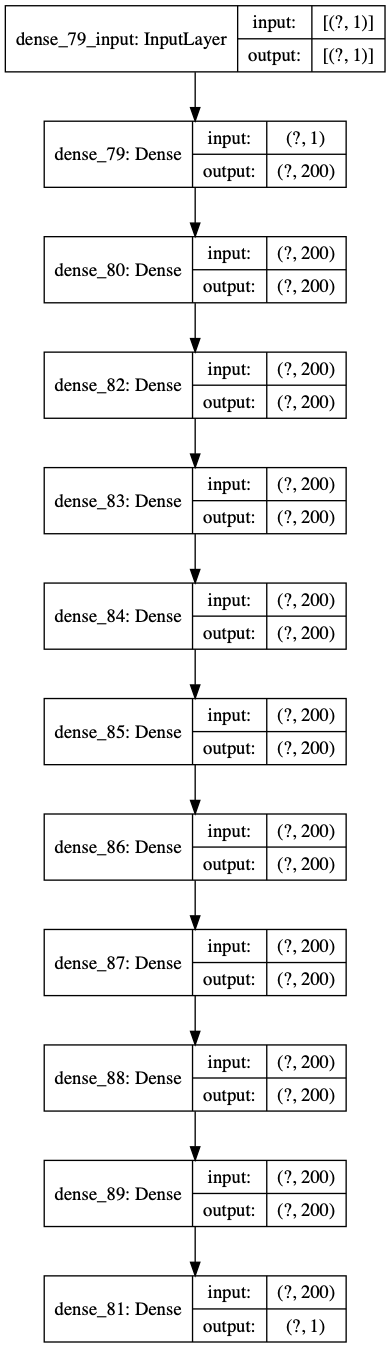

In [86]:
tf.keras.utils.plot_model(models[-1], show_shapes=True)

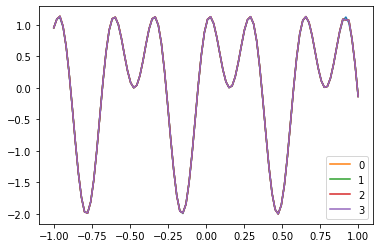

In [80]:
plt.figure()
plt.plot(x, y)
for i, model in enumerate(models):
    plt.plot(x, model.predict(x), label=f'{i}')
plt.legend()

(1e-12, 1)

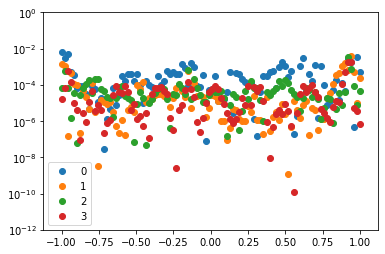

In [81]:
plt.figure()
for i, loss in enumerate(losses):
    plt.scatter(x, loss, label=f'{i}')
plt.legend()
plt.yscale('log')
plt.ylim(1e-12, 1)

# look at base model layers

In [87]:
%%time
base_history, base_model = get_base_model(x, y, verbose=False)

CPU times: user 2.2 s, sys: 340 ms, total: 2.54 s
Wall time: 1.24 s


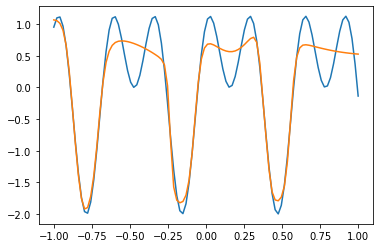

In [88]:
plt.figure()
plt.plot(x, y)
plt.plot(x, base_model.predict(x))

In [89]:
base_model.inputs

[<tf.Tensor 'dense_90_input:0' shape=(None, 1) dtype=float32>]

In [107]:
base_model.layers[0].activation

<function tensorflow.python.keras.activations.tanh(x)>

In [108]:
base_model.layers[1].activation

<function tensorflow.python.keras.activations.tanh(x)>

In [109]:
base_model.layers[2].activation

<function tensorflow.python.keras.activations.linear(x)>

In [91]:
base_model.outputs

[<tf.Tensor 'dense_92/Identity:0' shape=(None, 1) dtype=float32>]

In [125]:
aux_model = tf.keras.Model(inputs=base_model.inputs,
                          outputs=base_model.outputs + [base_model.layers[0].output, base_model.layers[1].output])

In [126]:
final_output, hidden_1_output, hidden_2_output = aux_model.predict(x)

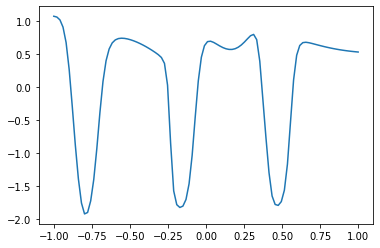

In [127]:
plt.figure()
plt.plot(x, final_output)

In [128]:
hidden_1_output.shape

(100, 200)

In [129]:
hidden_2_output.shape

(100, 200)

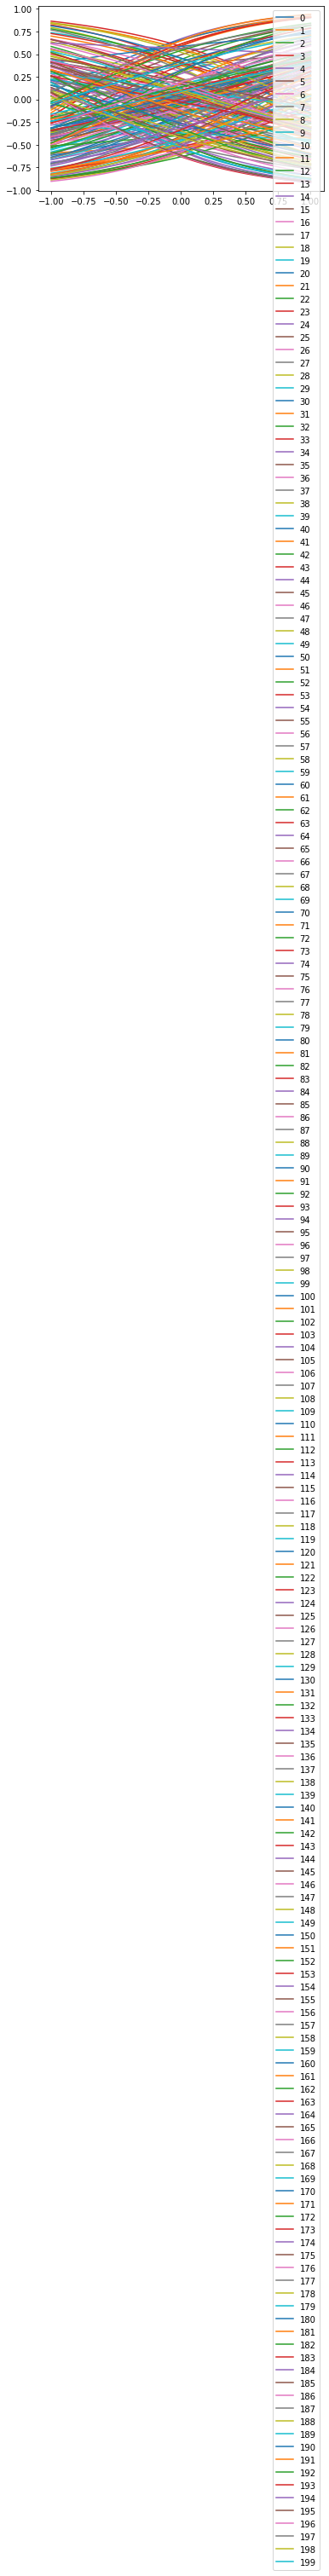

In [135]:
plt.figure()
for i, h1 in enumerate(hidden_1_output.T):
    plt.plot(x, h1, label=f'{i}')
plt.legend()

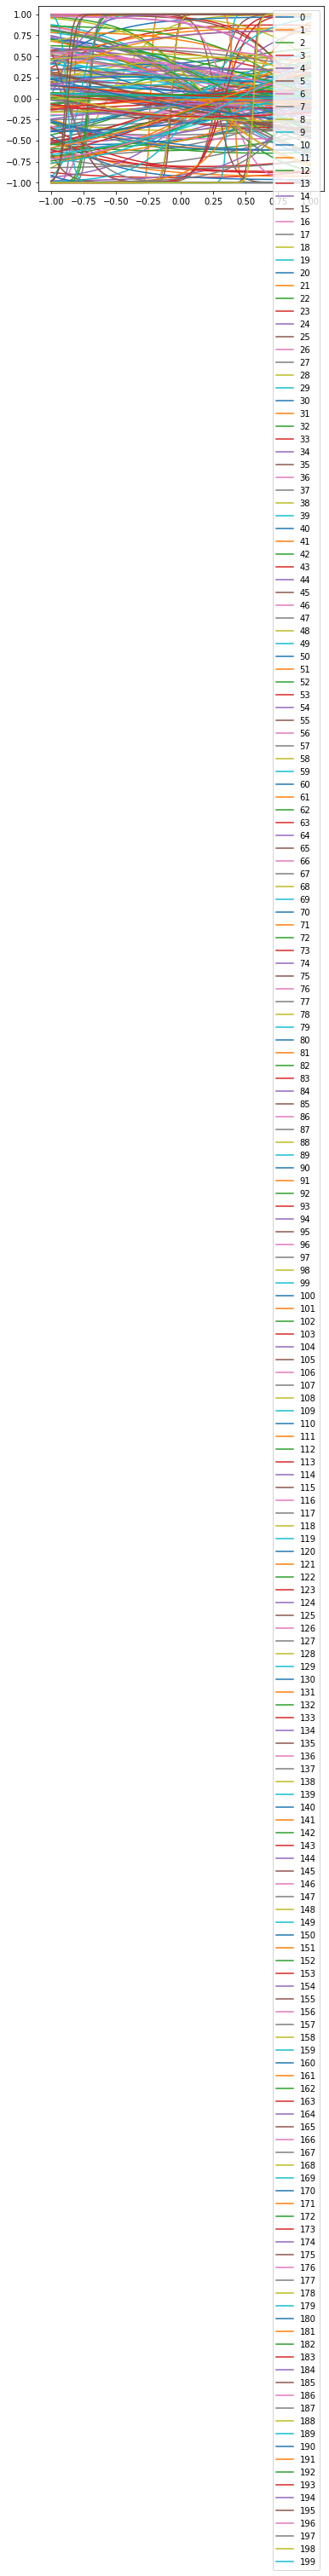

In [136]:
plt.figure()
for i, h1 in enumerate(hidden_2_output.T):
    plt.plot(x, h1, label=f'{i}')
plt.legend()

<tf.Tensor: shape=(), dtype=float32, numpy=0.013851722>

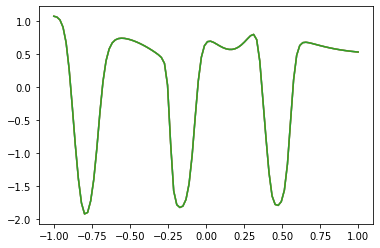

In [164]:
# test I can do forward propagation manually
plt.plot(x, tf.matmul(tf.transpose(base_model.layers[-1].weights[0]), hidden_2_output.T).numpy().T+base_model.layers[-1].bias[0])
plt.plot(x, final_output)
plt.plot(x, base_model.predict(x))

In [ ]:
# from SO
# https://stackoverflow.com/a/59522106/12840171
# import tensorflow as tf

# # This is the original model.
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
#     tf.keras.layers.Dense(100, activation="relu"),
#     tf.keras.layers.Dense(10, activation="softmax")])

# # Make an auxiliary model that exposes the output from the intermediate layer
# # of interest, which is the first Dense layer in this case.
# aux_model = tf.keras.Model(inputs=model.inputs,
#                            outputs=model.outputs + [model.layers[1].output])

# # Access both the final and intermediate output of the original model
# # by calling `aux_model.predict()`.
# final_output, intermediate_layer_output = aux_model.predict(some_input)